# Modelos
### XGBoost - Decision Tree - Random Forest - Logistic Regression - LightGBM

Levanta data_df.csv generado por EDA.

In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

In [81]:
# Lectura del dataset generado en el proceso de EDA.
df = pd.read_csv('data_df.csv')

# df=df.drop(['Unnamed: 0'], axis=1) # Elimino la columna que me generó el pd.write_csv() del EDA.

In [82]:
df.columns

Index(['pol', 'endoso', 'item', 'fecemi', 'tipend', 'idaseg', 'ase_antig_an',
       'ase_cp', 'ase_codnac', 'ase_nac', 'idprod', 'pro_antig_an', 'tipveh',
       'marca', 'modelo', 'anio', 'uso', 'uso_desc', 'cober', 'codcober',
       'cober_desc', 'cob_fecuma', 'cob_ef', 'fraude'],
      dtype='object')

In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 469370 entries, 0 to 469369
Data columns (total 24 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   pol           469370 non-null  int64  
 1   endoso        469370 non-null  int64  
 2   item          469370 non-null  int64  
 3   fecemi        469370 non-null  int64  
 4   tipend        469370 non-null  object 
 5   idaseg        469370 non-null  int64  
 6   ase_antig_an  469370 non-null  int64  
 7   ase_cp        469370 non-null  int64  
 8   ase_codnac    469370 non-null  float64
 9   ase_nac       469370 non-null  object 
 10  idprod        469370 non-null  int64  
 11  pro_antig_an  469370 non-null  int64  
 12  tipveh        469370 non-null  int64  
 13  marca         469370 non-null  int64  
 14  modelo        469370 non-null  int64  
 15  anio          469370 non-null  int64  
 16  uso           469370 non-null  int64  
 17  uso_desc      469370 non-null  object 
 18  cobe

In [84]:
# Feature selection
# df con las variables independientes a incluir en el modelo. Surgen del EDA realizado.
# dfModel =df.drop('fraude', axis=1)
# 
dfModel=df[['endoso', 'ase_antig_an', 'ase_cp', 'ase_codnac', 'idprod', 'pro_antig_an', 
            'marca', 'modelo', 'anio', 'uso', 'codcober', 'cob_ef']]

In [85]:
# Es la variable dependiente/objetivo/target 'fraude'
dfTarget=df['fraude']

In [86]:
# Divido en training y testing. 
X_train, X_test, y_train, y_test = train_test_split(dfModel, dfTarget, test_size = 0.3, random_state=45)

In [87]:
print("Training 0: %.0f" % (y_train.count()))
print("Training 1: %.0f" % (y_train.sum()))
print("            %.4f%%" % (y_train.sum() / y_train.count()))
print("")
print("Testing 0: %.0f" % (y_test.count()))
print("Testing 1: %.0f" % (y_test.sum()))
print("           %.4f%%" % (y_test.sum() / y_test.count()))

Training 0: 328559
Training 1: 12140
            0.0369%

Testing 0: 140811
Testing 1: 5096
           0.0362%


In [88]:
# Divido en training y testing. Utilizo 'stratify' para mantener la proporción de positivos y negativos en train y test.
X_train, X_test, y_train, y_test = train_test_split(dfModel, dfTarget, test_size = 0.3, random_state=45, stratify=dfTarget)

In [89]:
print("Training 0: %.0f" % (y_train.count()))
print("Training 1: %.0f" % (y_train.sum()))
print("            %.4f%%" % (y_train.sum() / y_train.count()))
print("")
print("Testing 0: %.0f" % (y_test.count()))
print("Testing 1: %.0f" % (y_test.sum()))
print("           %.4f%%" % (y_test.sum() / y_test.count()))

Training 0: 328559
Training 1: 12065
            0.0367%

Testing 0: 140811
Testing 1: 5171
           0.0367%


###  ---Algoritmo XGBoost con BO---

In [90]:
# !pip install xgboost
import xgboost as xgb
from xgboost import XGBClassifier ## Categorical target variable
# from xgboost import XGBRegressor ## Continuous target variable

In [91]:
def xgb_classifier(n_estimators, max_depth, reg_alpha, reg_lambda, min_child_weight, num_boost_round, gamma):
    params = {"booster": 'gbtree',
              "objective" : "binary:logistic",
              "eval_metric" : "auc", 
              "is_unbalance": True,
              "n_estimators": int(n_estimators),
              "max_depth" : int(max_depth),
              "reg_alpha" : reg_alpha,
              "reg_lambda" : reg_lambda,
              "gamma": gamma,
              "num_threads" : 20,
              "min_child_weight" : int(min_child_weight),
              "learning_rate" : 0.02,
              "subsample_freq" : 5,
              "seed" : 42,
              "verbosity" : 0,
              "num_boost_round": int(num_boost_round)}
    
    train_data = xgb.DMatrix(X_train, y_train)
    
    cv_result = xgb.cv(params, train_data, 1000, early_stopping_rounds=100, stratified=True, nfold=3)
    return cv_result['test-auc-mean'].iloc[-1]

In [92]:
# !pip install bayesian-optimization
from bayes_opt import BayesianOptimization
xgbBO = BayesianOptimization(xgb_classifier, {  'n_estimators': (10, 100),
                                                'max_depth': (5, 40),
                                                'reg_alpha': (0.0, 0.1),
                                                'reg_lambda': (0.0, 0.1),
                                                'min_child_weight': (1, 10),
                                                'num_boost_round': (100, 1000),
                                                "gamma": (0, 10)
                                                })

In [93]:
xgbBO.maximize(n_iter=20, init_points=2) # n_iter=35

In [94]:
xgbBO.max

In [95]:
# clf_xgb=XGBClassifier(use_label_encoder=False, 
#                       colsample_bytree = 0.5, 
#                       learning_rate = 0.2,
#                       gamma =  7.913757545198536,
#                       max_depth = 7,
#                       min_child_weight = 1.9202611553414282,
#                       alpha = 10, 
#                       n_estimators = 45,
#                       reg_alpha =   0.07711402098002348,
#                       reg_lambda = 0.0433274269286166,
#                       eval_metric='auc')

# n_estimators = 45

clf_xgb=XGBClassifier(use_label_encoder=False, 
                      colsample_bytree = 0.5, 
                      learning_rate = 0.2,
                      gamma =  8.141210926403971,
                      max_depth = 10,
                      min_child_weight = 6.779723064345376,
                      alpha = 10, 
                      n_estimators = 50,
                      reg_alpha = 0.08672170218151724,
                      reg_lambda = 0.048019737256687234,
                      eval_metric='auc')

In [96]:
# Fitting model
clf_xgb.fit(X_train, y_train)

XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, eval_metric='auc',
              gamma=8.141210926403971, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.2, max_delta_step=0,
              max_depth=10, min_child_weight=6.779723064345376, missing=nan,
              monotone_constraints='()', n_estimators=50, n_jobs=4,
              num_parallel_tree=1, random_state=0,
              reg_alpha=0.08672170218151724, reg_lambda=0.048019737256687234,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

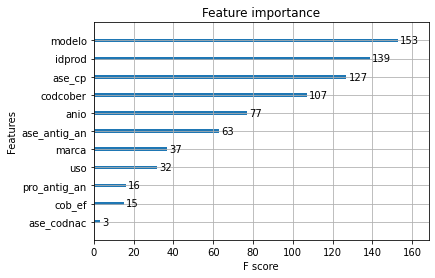

In [97]:
# la variable que mas toma en cuenta el clasificador.
xgb.plot_importance(clf_xgb, ax=plt.gca())
y_pred  = clf_xgb.predict(X_test)

In [98]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98    135640
           1       0.56      0.59      0.58      5171

    accuracy                           0.97    140811
   macro avg       0.77      0.79      0.78    140811
weighted avg       0.97      0.97      0.97    140811



In [99]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[133215,   2425],
       [  2098,   3073]], dtype=int64)

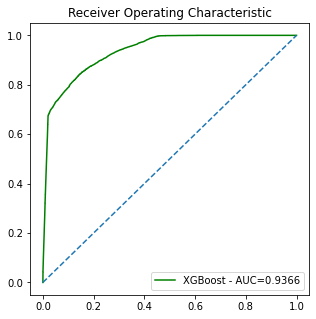

In [100]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

y_pred_proba = clf_xgb.predict_proba(X_test)[::,1]
fpr_xgb, tpr_xgb, _ = roc_curve(y_test,  y_pred_proba)
auc_xgb = roc_auc_score(y_test, y_pred_proba)
plt.figure(figsize=(5,5))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_xgb,tpr_xgb,color="green",label="XGBoost - AUC=%.4f" % auc_xgb)
plt.plot([0, 1], [0, 1],linestyle='--')
plt.legend(loc=4)
plt.show()

### ---Decision Tree---

In [101]:
# Load libraries
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

In [102]:
# Create Decision Tree classifer object
clf_dt = DecisionTreeClassifier()
# Train Decision Tree Classifer
clf_dt = clf_dt.fit(X_train,y_train)
#Predict the response for test dataset
y_pred = clf_dt.predict(X_test)

In [103]:
# Visualizing Decision Trees
# !pip install StringIO

# from sklearn.externals.six import StringIO  
# from IPython.display import Image  
# from sklearn.tree import export_graphviz
# import pydotplus
# dot_data = StringIO()
# export_graphviz(clf_dt, out_file=dot_data,  
#                 filled=True, rounded=True,
#                 special_characters=True, feature_names = feature_cols,class_names=['0','1'])
# graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
# graph.write_png('decision_tree.png')
# Image(graph.create_png())

In [104]:
# view accuracy
# from sklearn.metrics import accuracy_score
accuracy=accuracy_score(y_pred, y_test)
print('Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))

Model accuracy score: 0.9535


In [105]:
y_pred_train = clf_dt.predict(X_train)

In [106]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98    135640
           1       0.37      0.38      0.38      5171

    accuracy                           0.95    140811
   macro avg       0.67      0.68      0.68    140811
weighted avg       0.95      0.95      0.95    140811



In [107]:
confusion_matrix(y_test, y_pred)

array([[132288,   3352],
       [  3199,   1972]], dtype=int64)

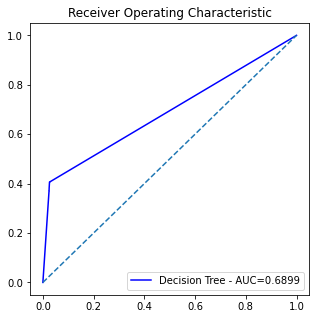

In [108]:
y_pred_proba = clf_dt.predict_proba(X_test)[::,1]
fpr_dt, tpr_dt, _ = roc_curve(y_test,  y_pred_proba)
auc_dt = roc_auc_score(y_test, y_pred_proba)
plt.figure(figsize=(5,5))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_dt,tpr_dt,color="blue",label="Decision Tree - AUC=%.4f" % auc_dt)
plt.plot([0, 1], [0, 1],linestyle='--')
plt.legend(loc=4)
plt.show()

### ---Random Forest---

In [109]:
# Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier
# Create a Gaussian Classifier
clf_rf=RandomForestClassifier(n_estimators=100)
# Train the model using the training sets y_pred=clf.predict(X_test)
clf_rf.fit(X_train,y_train)
y_pred=clf_rf.predict(X_test)

In [110]:
# feature_imp = pd.Series(clf.feature_importances_,index=df.feature_names).sort_values(ascending=False)
feature_imp = pd.Series(clf_rf.feature_importances_).sort_values(ascending=False)
feature_imp

4     0.305272
7     0.157811
10    0.154185
1     0.084625
2     0.079426
9     0.076846
8     0.075957
6     0.045841
5     0.010019
11    0.009582
3     0.000346
0     0.000089
dtype: float64

In [111]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98    135640
           1       0.53      0.39      0.45      5171

    accuracy                           0.96    140811
   macro avg       0.75      0.69      0.72    140811
weighted avg       0.96      0.96      0.96    140811



In [112]:
confusion_matrix(y_test, y_pred)

array([[133819,   1821],
       [  3144,   2027]], dtype=int64)

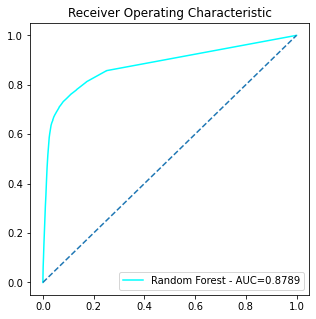

In [113]:
y_pred_proba = clf_rf.predict_proba(X_test)[::,1]
fpr_rf, tpr_rf, _ = roc_curve(y_test,  y_pred_proba)
auc_rf = roc_auc_score(y_test, y_pred_proba)
plt.figure(figsize=(5,5))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_rf,tpr_rf,color="cyan",label="Random Forest - AUC=%.4f" % auc_rf)
plt.plot([0, 1], [0, 1],linestyle='--')
plt.legend(loc=4)
plt.show()

### ---Logistic Regression---

In [114]:
# import the class
from sklearn.linear_model import LogisticRegression
# instantiate the model (using the default parameters)
clf_lr=LogisticRegression(solver='liblinear', random_state=0)
# fit the model with data
clf_lr.fit(X_train,y_train)
y_pred=clf_lr.predict(X_test)

In [115]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98    135640
           1       0.58      0.06      0.12      5171

    accuracy                           0.96    140811
   macro avg       0.77      0.53      0.55    140811
weighted avg       0.95      0.96      0.95    140811



In [116]:
confusion_matrix(y_test, y_pred)

array([[135398,    242],
       [  4836,    335]], dtype=int64)

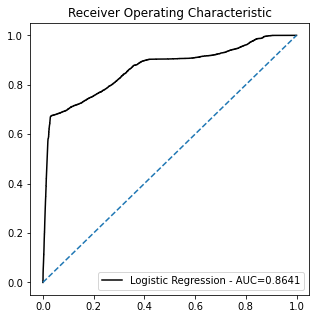

In [117]:
y_pred_proba = clf_lr.predict_proba(X_test)[::,1]
fpr_lr, tpr_lr, _ = roc_curve(y_test,  y_pred_proba)
auc_lr = roc_auc_score(y_test, y_pred_proba)
plt.figure(figsize=(5,5))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_lr,tpr_lr,color="black",label="Logistic Regression - AUC=%.4f" % auc_lr)
plt.plot([0, 1], [0, 1],linestyle='--')
plt.legend(loc=4)
plt.show()

### ---LightGBM---

In [118]:
# build the lightgbm model
import lightgbm as lgb
clf_lgbm = lgb.LGBMClassifier()
clf_lgbm.fit(X_train, y_train)

# predict the results
y_pred=clf_lgbm.predict(X_test)

In [119]:
y_pred_train = clf_lgbm.predict(X_train)

In [120]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98    135640
           1       0.56      0.61      0.58      5171

    accuracy                           0.97    140811
   macro avg       0.77      0.79      0.78    140811
weighted avg       0.97      0.97      0.97    140811



In [121]:
confusion_matrix(y_test, y_pred)

array([[133144,   2496],
       [  2032,   3139]], dtype=int64)

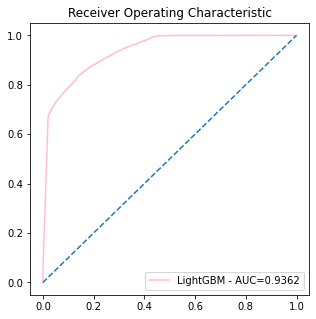

In [122]:
y_pred_proba = clf_lgbm.predict_proba(X_test)[::,1]
fpr_lgbm, tpr_lgbm, _ = roc_curve(y_test,  y_pred_proba)
auc_lgbm = roc_auc_score(y_test, y_pred_proba)
plt.figure(figsize=(5,5))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_lgbm,tpr_lgbm,color="pink",label="LightGBM - AUC=%.4f" % auc_lgbm)
plt.plot([0, 1], [0, 1],linestyle='--')
plt.legend(loc=4)
plt.show()

### ROC Curve y AUC - Todos los modelos

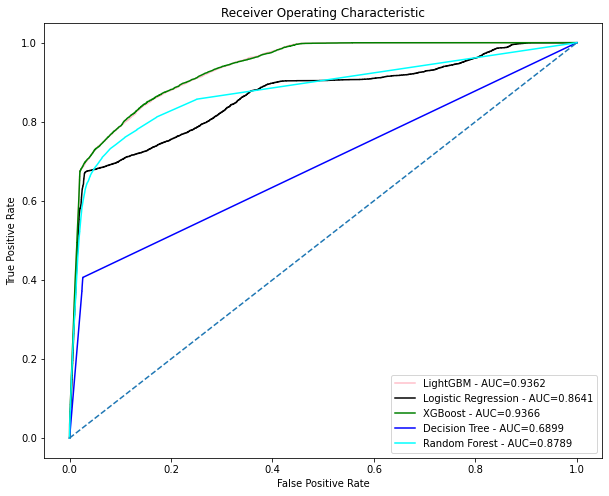

In [123]:
plt.figure(figsize=(10,8))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_lgbm,tpr_lgbm,color="pink",label="LightGBM - AUC=%.4f" % auc_lgbm)
plt.plot(fpr_lr,tpr_lr,color="black",label="Logistic Regression - AUC=%.4f" % auc_lr)
plt.plot(fpr_xgb,tpr_xgb,color="green",label="XGBoost - AUC=%.4f" % auc_xgb)
plt.plot(fpr_dt,tpr_dt,color="blue",label="Decision Tree - AUC=%.4f" % auc_dt)
plt.plot(fpr_rf,tpr_rf,color="cyan",label="Random Forest - AUC=%.4f" % auc_rf)
plt.plot([0, 1], [0, 1],linestyle='--')
plt.legend(loc=4)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.savefig('ROC_Curve_Modelos.jpg')
plt.show()

In [124]:
from sklearn.model_selection import cross_val_score

# Applying k-Fold Cross Validation
roc_auc_score_xgb  = cross_val_score(estimator = clf_xgb , X = X_train, y = y_train, cv = 5, scoring='roc_auc')
roc_auc_score_dt   = cross_val_score(estimator = clf_dt  , X = X_train, y = y_train, cv = 5, scoring='roc_auc')
roc_auc_score_rf   = cross_val_score(estimator = clf_rf  , X = X_train, y = y_train, cv = 5, scoring='roc_auc')
roc_auc_score_lr   = cross_val_score(estimator = clf_lr  , X = X_train, y = y_train, cv = 5, scoring='roc_auc')
roc_auc_score_lgbm = cross_val_score(estimator = clf_lgbm, X = X_train, y = y_train, cv = 5, scoring='roc_auc')

In [125]:
print("XGBoost - 5-fold cross validation - AUC mean            : %.4f" % roc_auc_score_xgb.mean())
print("Decision Tree - 5-fold cross validation - AUC mean      : %.4f" % roc_auc_score_dt.mean())
print("Random Forest - 5-fold cross validation - AUC mean      : %.4f" % roc_auc_score_rf.mean())
print("Logistic Regression - 5-fold cross validation - AUC mean: %.4f" % roc_auc_score_lr.mean())
print("LightGBM - 5-fold cross validation - AUC mean           : %.4f" % roc_auc_score_lgbm.mean())

XGBoost - 5-fold cross validation - AUC mean            : 0.9370
Decision Tree - 5-fold cross validation - AUC mean      : 0.6909
Random Forest - 5-fold cross validation - AUC mean      : 0.8757
Logistic Regression - 5-fold cross validation - AUC mean: 0.8600
LightGBM - 5-fold cross validation - AUC mean           : 0.9367


In [126]:
df_roc_auc_score_xgb=pd.DataFrame(roc_auc_score_xgb)
df_roc_auc_score_dt=pd.DataFrame(roc_auc_score_dt)
df_roc_auc_score_rf=pd.DataFrame(roc_auc_score_rf)
df_roc_auc_score_lr=pd.DataFrame(roc_auc_score_lr)
df_roc_auc_score_lgbm=pd.DataFrame(roc_auc_score_lgbm)

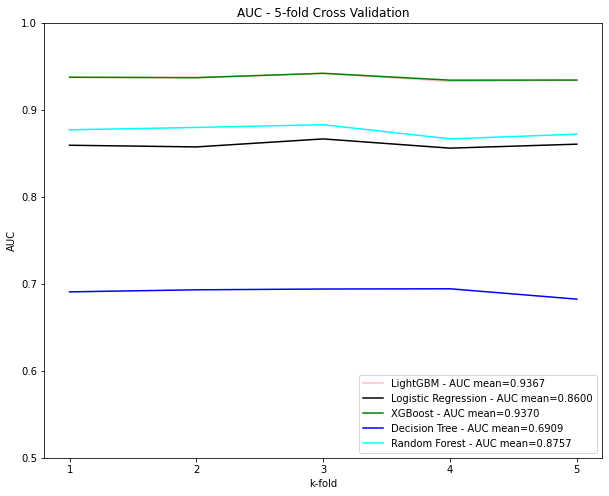

In [160]:
plt.figure(figsize=(10,8))
plt.title('AUC - 5-fold Cross Validation')
plt.plot(df_roc_auc_score_lgbm,color="pink",label="LightGBM - AUC mean=%.4f" % df_roc_auc_score_lgbm.mean())
plt.plot(df_roc_auc_score_lr,color="black",label="Logistic Regression - AUC mean=%.4f" % df_roc_auc_score_lr.mean())
plt.plot(df_roc_auc_score_xgb,color="green",label="XGBoost - AUC mean=%.4f" % df_roc_auc_score_xgb.mean())
plt.plot(df_roc_auc_score_dt,color="blue",label="Decision Tree - AUC mean=%.4f" % df_roc_auc_score_dt.mean())
plt.plot(df_roc_auc_score_rf,color="cyan",label="Random Forest - AUC mean=%.4f" % df_roc_auc_score_rf.mean())
plt.legend(loc=4)
plt.xlabel("k-fold")
plt.ylabel("AUC")
x_ticks=[0,1,2,3,4]
x_labels=[1,2,3,4,5]
plt.xticks(ticks=x_ticks, labels=x_labels)
plt.ylim(0.5, 1)
plt.savefig('cv 5-fold.jpg')
plt.show()

### En base al rendimiento demostrado, se elige ---XGBoost--- como el algoritmo a desarrollar. 
También podría desarrolla LightGBM dado que tiene un rendimiento muy similar.

In [128]:
# comienzo nuevo proceso.

### Feature Engineering

In [129]:
# Anio Fecha Ultima Cobranza.
df['Fe_New1'] = pd.to_numeric(df['cob_fecuma'].astype(str).str.slice(0,4))

In [130]:
# Mes Fecha Ultima Cobranza.
df['Fe_New2'] = pd.to_numeric(df['cob_fecuma'].astype(str).str.slice(4,6))

In [131]:
# Anio Fecha Emisión de la Operación.
df['Fe_New3'] = pd.to_numeric(df['fecemi'].astype(str).str.slice(0,4))

In [132]:
# Mes Emisión de la Operación.
df['Fe_New4'] = pd.to_numeric(df['fecemi'].astype(str).str.slice(4,6))

In [133]:
# la diferencia entre el día de proceso y la última cobranza.
df['Fe_New5'] = (pd.Timestamp.now().normalize()-pd.to_datetime(df['cob_fecuma'], format='%Y%m%d')).dt.days

In [134]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 469370 entries, 0 to 469369
Data columns (total 29 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   pol           469370 non-null  int64  
 1   endoso        469370 non-null  int64  
 2   item          469370 non-null  int64  
 3   fecemi        469370 non-null  int64  
 4   tipend        469370 non-null  object 
 5   idaseg        469370 non-null  int64  
 6   ase_antig_an  469370 non-null  int64  
 7   ase_cp        469370 non-null  int64  
 8   ase_codnac    469370 non-null  float64
 9   ase_nac       469370 non-null  object 
 10  idprod        469370 non-null  int64  
 11  pro_antig_an  469370 non-null  int64  
 12  tipveh        469370 non-null  int64  
 13  marca         469370 non-null  int64  
 14  modelo        469370 non-null  int64  
 15  anio          469370 non-null  int64  
 16  uso           469370 non-null  int64  
 17  uso_desc      469370 non-null  object 
 18  cobe

### Feature Selection

In [135]:
dfModel=df[['endoso', 'ase_antig_an', 'ase_cp', 'ase_codnac', 'idprod', 'pro_antig_an', 
            'marca', 'modelo', 'anio', 'uso', 'codcober', 'cob_ef', 
            'Fe_New1', 'Fe_New2', 'Fe_New3', 'Fe_New4', 'Fe_New5']]

In [136]:
# Es la variable dependiente/objetivo/target 'fraude'
dfTarget=df['fraude']

In [137]:
# Divido en training y testing. Utilizo 'stratify' para mantener la proporción de positivos y negativos en train y test.
X_train, X_test, y_train, y_test = train_test_split(dfModel, dfTarget, test_size = 0.3, random_state=45, stratify=dfTarget)

In [138]:
print("Training 0: %.0f" % (y_train.count()))
print("Training 1: %.0f" % (y_train.sum()))
print("            %.4f%%" % (y_train.sum() / y_train.count()))
print("")
print("Testing 0: %.0f" % (y_test.count()))
print("Testing 1: %.0f" % (y_test.sum()))
print("           %.4f%%" % (y_test.sum() / y_test.count()))

Training 0: 328559
Training 1: 12065
            0.0367%

Testing 0: 140811
Testing 1: 5171
           0.0367%


In [139]:
# !pip install xgboost
import xgboost as xgb
from xgboost import XGBClassifier ## Categorical target variable
# from xgboost import XGBRegressor ## Continuous target variable

In [140]:
def xgb_classifier(n_estimators, max_depth, reg_alpha, reg_lambda, min_child_weight, num_boost_round, gamma):
    params = {"booster": 'gbtree',
              "objective" : "binary:logistic",
              "eval_metric" : "auc", 
              "is_unbalance": True,
              "n_estimators": int(n_estimators),
              "max_depth" : int(max_depth),
              "reg_alpha" : reg_alpha,
              "reg_lambda" : reg_lambda,
              "gamma": gamma,
              "num_threads" : 20,
              "min_child_weight" : int(min_child_weight),
              "learning_rate" : 0.02,
              "subsample_freq" : 5,
              "seed" : 42,
              "verbosity" : 0,
              "num_boost_round": int(num_boost_round)}
    
    train_data = xgb.DMatrix(X_train, y_train, enable_categorical=True)
    
    cv_result = xgb.cv(params, train_data, 1000, early_stopping_rounds=100, stratified=True, nfold=3)
    return cv_result['test-auc-mean'].iloc[-1]

In [141]:
# !pip install bayesian-optimization
from bayes_opt import BayesianOptimization
xgbBO = BayesianOptimization(xgb_classifier, {  'n_estimators': (10, 100),
                                                'max_depth': (5, 40),
                                                'reg_alpha': (0.0, 0.1),
                                                'reg_lambda': (0.0, 0.1),
                                                'min_child_weight': (1, 10),
                                                'num_boost_round': (100, 1000),
                                                "gamma": (0, 10)
                                                })

In [142]:
xgbBO.maximize(n_iter=50, init_points=2)

In [143]:
xgbBO.max

In [144]:
# clf_xgb=XGBClassifier(use_label_encoder=False, 
#                      colsample_bytree = 0.5, 
#                      learning_rate = 0.2,
#                      gamma =  7.913757545198536,
#                      max_depth = 7,
#                      min_child_weight = 1.9202611553414282,
#                      alpha = 10, 
#                      n_estimators = 45,
#                      reg_alpha =   0.07711402098002348,
#                      reg_lambda = 0.0433274269286166,
#                      eval_metric='auc')

clf_xgb=XGBClassifier(use_label_encoder=False, 
                     colsample_bytree = 0.5, 
                     learning_rate = 0.2,
                     gamma =  6.081126098947912,
                     max_depth = 11,
                     min_child_weight = 3.7100170137477195,
                     alpha = 10, 
                     n_estimators = 98,
                     reg_alpha =  0.07314087105844085,
                     reg_lambda = 0.02258529645486931,
                     eval_metric='auc')

In [145]:
# Fitting model
clf_xgb.fit(X_train, y_train)

XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, eval_metric='auc',
              gamma=6.081126098947912, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.2, max_delta_step=0,
              max_depth=11, min_child_weight=3.7100170137477195, missing=nan,
              monotone_constraints='()', n_estimators=98, n_jobs=4,
              num_parallel_tree=1, random_state=0,
              reg_alpha=0.07314087105844085, reg_lambda=0.02258529645486931,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

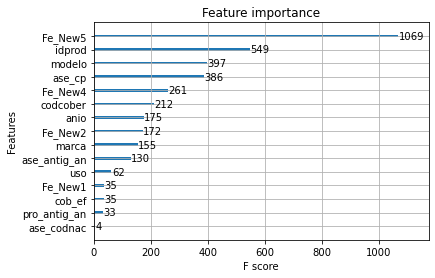

In [146]:
# la variable que mas toma en cuenta el clasificador.
xgb.plot_importance(clf_xgb, ax=plt.gca())
y_pred  = clf_xgb.predict(X_test)

In [147]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    135640
           1       0.98      0.65      0.78      5171

    accuracy                           0.99    140811
   macro avg       0.98      0.83      0.89    140811
weighted avg       0.99      0.99      0.99    140811



In [148]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[135558,     82],
       [  1785,   3386]], dtype=int64)

### ROC Curve y AUC modelo antes y después de Feature Engineering

The ROC curve shows the trade-off between sensitivity (or TPR) and specificity (1 – FPR). Classifiers that give curves closer to the top-left corner indicate a better performance. As a baseline, a random classifier is expected to give points lying along the diagonal (FPR = TPR). The closer the curve comes to the 45-degree diagonal of the ROC space, the less accurate the test.

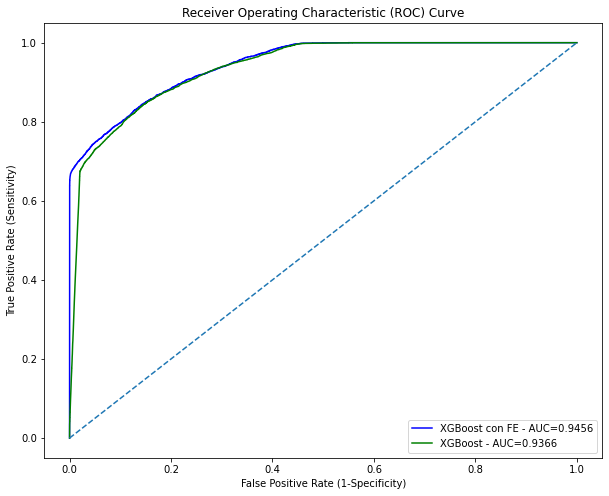

In [149]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

y_pred_proba = clf_xgb.predict_proba(X_test)[::,1]
fpr_xgb_Fe, tpr_xgb_Fe, _ = roc_curve(y_test,  y_pred_proba)
auc_xgb_Fe = roc_auc_score(y_test, y_pred_proba)
plt.figure(figsize=(10,8))
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.plot(fpr_xgb_Fe,tpr_xgb_Fe,color="blue",label="XGBoost con FE - AUC=%.4f" % auc_xgb_Fe)
plt.plot(fpr_xgb,tpr_xgb,color="green",label="XGBoost - AUC=%.4f" % auc_xgb)
plt.plot([0, 1], [0, 1],linestyle='--')
plt.legend(loc=4)
plt.xlabel("False Positive Rate (1-Specificity)")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.savefig('ROC_Curve_Final.jpg')
plt.show()